In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from py_extrema.extrema import ExtremaFinder, CriticalPoints
from FyeldGenerator import generate_field
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import ipyvolume.pylab as p3

from scipy.interpolate import interp1d, RegularGridInterpolator
from collections import defaultdict
from tqdm import tqdm
import pandas as pd


from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (12, 9)

/home/ccc/Documents/prog/py_extrema/py_extrema/utils.py:132: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function trilinear_interpolation failed at nopython mode lowering due to: No definition for lowering <built-in function getitem>(array(float64, 1d, A), ...) -> array(float64, 1d, A)

File "py_extrema/utils.py", line 168:
def trilinear_interpolation(pos, v, ret):
    <source elided>
                vol = x[i] * y[j] * z[k]
                ret[...] += v[..., i, j, k] * vol
                ^

[1] During: lowering "$130binary_subscr.19 = static_getitem(value=ret, index=Ellipsis, index_var=$const126.16)" at /home/ccc/Documents/prog/py_extrema/py_extrema/utils.py (168)
  @guvectorize(['void(float64[:], float64[:,:,:,:], float64[:])'],
/home/ccc/anaconda3/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "trilinear_interpolation" was compiled in object mode without forceobj=True.

File "py_extrema/utils.py"

In [3]:
# Helper that generates power-law power spectrum
def Pkgen(n):
    def Pk(k):
        return np.power(k, -n)

    return Pk

# Draw samples from a normal distribution
def distrib(shape):
    a = np.random.normal(loc=0, scale=1, size=shape)
    b = np.random.normal(loc=0, scale=1, size=shape)
    return a + 1j * b

In [4]:
np.random.seed(16091992)

ndim = 2
field = generate_field(distrib, Pkgen(2), [512]*ndim)
field3D = generate_field(distrib, Pkgen(2), [128]*3)

## Detecting extrema alone

In [5]:
ef = ExtremaFinder(field, nthreads=4, loglevel=30)

In [6]:
ef.find_extrema(10)
curvature = ef.curvature

In [7]:
pts = defaultdict(CriticalPoints)

R0 = 5
R1 = 10
curv = np.zeros(field.shape)
skip = True
for R in np.geomspace(R0, 256, 10):
    ef.compute_derivatives(R)
    if skip:
        prev_curv = ef.curvature.copy()
        skip = False
        continue
    curv = ef.curvature
    
    mask = (prev_curv * curv) < 0
    print(R, mask.sum())
    prev_curv[...] = curv.copy()

7.742636826811272 74573
11.989685006378819 74266
18.566355334451114 71337
28.750509310437018 66595
44.52095043531399 82274
68.94191008102028 72560
106.75843438080376 75411
165.31835712190514 50953
256.0 16431


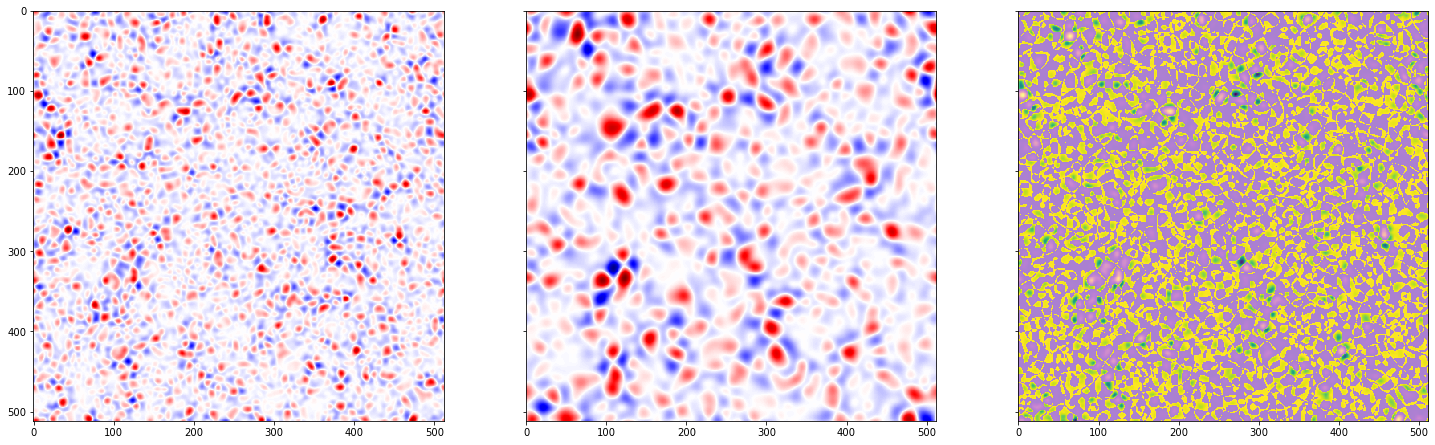

In [8]:
_, axes = plt.subplots(ncols=3, figsize=(25, 8.3), sharex=True, sharey=True, squeeze=True)

ef.compute_derivatives(R0)
c0 = ef.curvature.copy()
ef.compute_derivatives(R1)
c1 = ef.curvature.copy()

mm = np.abs(c0).max()
axes[0].imshow(c0, vmin=-mm, vmax=mm, cmap='seismic')

mm = np.abs(c1).max()
axes[1].imshow(c1, vmin=-mm, vmax=mm, cmap='seismic')

c2 = c0*c1
mm = np.abs(c2.min())
mask = c2 < 0
axes[2].imshow(c2, cmap='plasma', alpha=.5)
axes[2].imshow(np.where(mask, c2, np.nan))

/home/ccc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less
/home/ccc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater


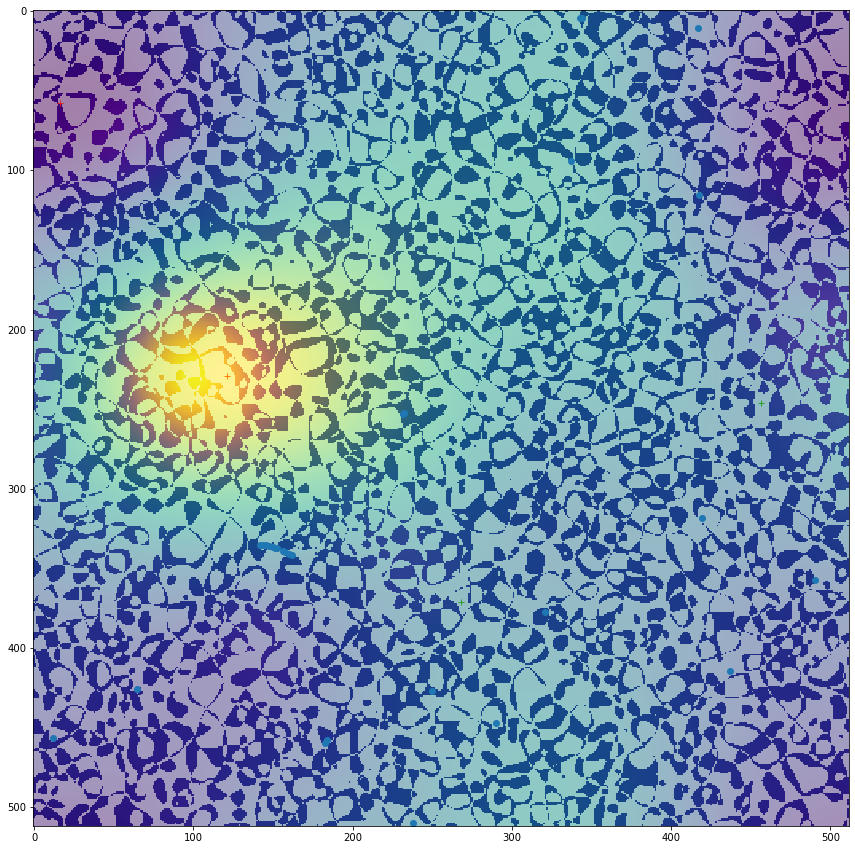

In [9]:
R0 = 60
R1 = R0*1.05

ef.compute_derivatives(R0)
c0 = ef.curvature.copy()

ef.compute_derivatives(R1)
c1 = ef.curvature.copy()

c2 = c0 * c1
eff = ExtremaFinder(c2, loglevel=50)

interp = RegularGridInterpolator([np.arange(s) for s in field.shape], c2, bounds_error=False)
ext = eff.find_extrema(R0*(0.05))
V = interp(ext.pos.value)

mask_ext = (ext.kind == ndim) & (V < 0)
significance = np.sqrt(np.abs(V / np.nanmin(V)))

mask_ext_sig = mask_ext & (significance > 0.1)

plt.figure(figsize=(15, 15))

# Plot curvature (product of lambdas)
plt.imshow(np.where(mask, c2, np.nan), cmap='plasma')
# and extrema of curvature
plt.plot(ext.pos[mask_ext_sig, 1], ext.pos[mask_ext_sig, 0], 'o')

# Plot field extrema
ext = ef.find_extrema(R0)
for k in range(ndim+1):
    m = ext.kind == k
    plt.plot(ext.pos[m, 1], ext.pos[m, 0], '+')
    
plt.imshow(ef.smooth(R0), alpha=0.5)

No handles with labels found to put in legend.


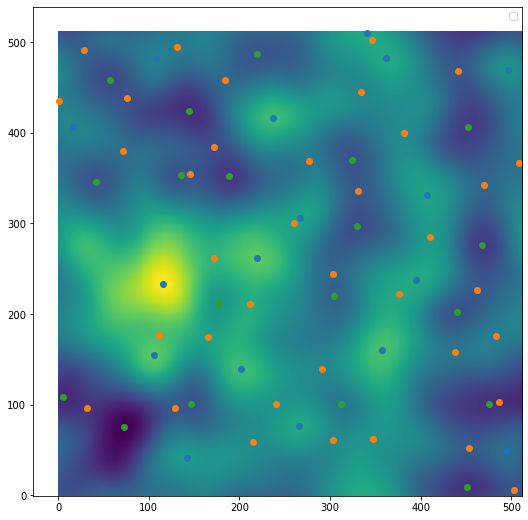

In [10]:
R = 20

pts = ef.find_extrema(R)

plt.imshow(ef.smooth(R), origin='lower')
# plt.plot(ef.smooth(R))
# interp = interp1d(np.arange(0, field.shape[0], 1, dtype=int), ef.smooth(R))
kinds = {0: 'max', 1: 's.p.', 2: 'min'}
for k in range(3):
    mask = pts.kind == k
    # plt.scatter(pts.pos[mask, 0], interp(pts.pos[mask, 0]), label=kinds[k])
    plt.scatter(pts.pos[mask, 1], pts.pos[mask, 0])
    
plt.legend()
# plt.xlim(0, 512)
# plt.ylim(0, 512)

## Detecting slopping saddle

In [11]:
from py_extrema.extrema import ExtremaFinder
from py_extrema.critical_events import CriticalEvents
import numpy as np

/home/ccc/Documents/prog/py_extrema/py_extrema/critical_events.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [12]:
ef = ExtremaFinder(field, nthreads=4, loglevel=30)
Rgrid = ef.array(np.geomspace(5, field.shape[0]/10, 30), 'pixel')
ce = CriticalEvents(ef, Rgrid)

In [13]:
df = ce.detect_events()
df = df.set_index(['iR'])

/home/ccc/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/home/ccc/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/home/ccc/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
df.groupby('kind').dens.mean()

kind
0    0.003165
1   -0.002873
Name: dens, dtype: float64

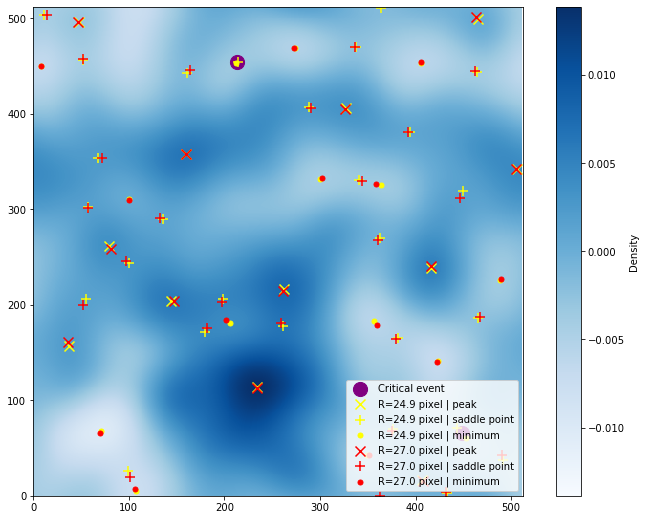

In [15]:
imax = 20
_df = df.loc[imax]
vmax = ef.smooth(Rgrid[imax]).max()
CB = plt.imshow(ef.smooth(Rgrid[imax]).T, cmap='Blues', vmin=-vmax, vmax=vmax)
ext0 = ef.find_extrema(Rgrid[imax])
ext1 = ef.find_extrema(Rgrid[imax+1])

plt.scatter(_df.x, _df.y, marker='o', c='purple', s=200, alpha=1, label='Critical event')
kind_labels = {0: 'peak', 1: 'saddle point', 2: 'minimum'}
for k, marker in zip(range(len(ef.data_shape)+1), 'x+.d'):
    plt.scatter(*ext0.pos[ext0.kind == k].T, marker=marker, c='yellow', s=100, label=f'R={Rgrid[imax]:.1f} | {kind_labels[k]}')

for k, marker in zip(range(len(ef.data_shape)+1), 'x+.d'):
    plt.scatter(*ext1.pos[ext1.kind == k].T, marker=marker, c='red', s=100, label=f'R={Rgrid[imax+1]:.1f} | {kind_labels[k]}')

plt.xlim(0, ef.data_shape[0])
plt.ylim(0, ef.data_shape[0])
plt.legend(loc='lower right')
colorbar = plt.colorbar(CB, ax=plt.gca())
colorbar.set_label('Density')